# Proyecto CDS (Clasificación/Detección/Segmentación)
Proyecto realizado para la asignatura 21781 - Aprendizaje Automático de la Universidad de las Islas Baleares

El siguiente proyecto ha sido realizado por:
- Rubén Ramis Martínez: ruben.ramis1@estudiant.uib.eu
- Emilio Salvador Fuster: emilio.salvador1@estudiant.uib.eu

# Introducción

AQUI PODEMOS HACER LA INTRODUCCIÓN DE LA PRÁCTICA (ORGANICEMOS UN POCO EL FICHERO COMO SI FUESE LA DOCUMENTACIÓN FINAL)

In [1]:
TRAIN = False
BATCH_SIZE = 64
BATCH_SIZE_MASK = 8
EPOCHS = 100
learning_rate = 1e-3

# Librerias
En la siguiente sección nos centraremos en los imports que se usarán.

In [2]:
%%capture
!pip install ultralytics
# Necesario tener la librería "gdown" para importar los datos
!pip install gdown

In [3]:
from glob import glob
from collections import OrderedDict

import numpy as np
import pylab as pl
from PIL import Image
from tqdm.auto import tqdm
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets, tv_tensors
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from ultralytics import YOLO, SAM

import scipy.io
import cv2
import os
import random
import time
from tempfile import TemporaryDirectory

C:\Users\Ramien\anaconda3\envs\AA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datos

Explicación de los datos que se van a usar.

Importación de los datos
Transformación
Train test
BACH

Calcula de la media y desviación de los datos

In [4]:
img_path = sorted(glob("./dataset/images/*.jpg"))
masks = sorted(glob("./dataset/labels/*.mat"))

class_names  = {}

for path_img in img_path:
    _, name = os.path.split(path_img)
    name = name.split(".")[0]
    name = name.split("_")[0]

    annotation = 0 if name == 'cannon' else 1
    
    class_names[path_img] = annotation

### DATASET CLASIFICACIÓN

In [5]:
class DatasetCaltechSimple(Dataset):
    def __init__(self, img_paths, annotations, transforms=None):
        super().__init__()
        self.img_paths = img_paths
        self.annotations = annotations
        self.transform = transforms

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        label = self.annotations[self.img_paths[idx]]

        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.img_paths)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    T.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),  # Rotación aleatoria
    transforms.RandomHorizontalFlip(),  # Volteo horizontal aleatorio
    transforms.Resize((224, 224)),  # Redimensiona la imagen
    transforms.Normalize(mean=[0.44849997758865356, 0.4266054630279541, 0.38514620065689087], std=[0.30377334356307983, 0.2932156026363373, 0.2906644344329834]),
])

train, test = train_test_split(img_path, random_state=42, test_size=0.25)

train_ds = DatasetCaltechSimple(train, class_names, transform)
test_ds = DatasetCaltechSimple(test, class_names, transform)

augmentation_factor = 5  # Esto hará que el dataset de entrenamiento se repita 5 veces

# Aumentar el dataset de entrenamiento repitiéndolo
augmented_train_ds = train_ds
for _ in range(augmentation_factor - 1):  # Restamos 1 porque ya tenemos el original
    augmented_train_ds = ConcatDataset([augmented_train_ds, train_ds])

# Crear los DataLoaders
train_loader = DataLoader(augmented_train_ds,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_loader = DataLoader(test_ds,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

dataset_size = len(train_ds)

C:\Users\Ramien\anaconda3\envs\AA\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### DATASET MASK-RCNN

In [7]:
class CaltechDatasetComplete(torch.utils.data.Dataset):
    def __init__(self, images, masks, annotations, transforms):
        self.transforms = transforms
        self.annotations = annotations
        self.paths = images
        self.mat = masks

    def __getitem__(self, idx):
        # load images and masks
        img = read_image(self.paths[idx])

        mat_data = scipy.io.loadmat(self.mat[idx])

        #Tratar con bounding boxes
        box_coord = mat_data.get('box_coord')
        num_objs = box_coord.shape[0]
        aux = []

        for box in box_coord:
            aux.append(box[[2,0,3,1]])

        box_coord = aux

        x1,y1,x2,y2 = box_coord[0]

        #Tratar con mascaras
        obj_contour = mat_data.get('obj_contour')

        masks = []
        for i in range(len(obj_contour[0])):
            masks.append([obj_contour[0][i] + x1, obj_contour[1][i] +y1])

        polygon = np.array(masks, dtype=np.int32)

        # Crear una imagen vacía (por ejemplo, de 300x300)
        mask = np.zeros((img.shape[1], img.shape[2]), dtype=np.uint8)
        
        # Dibujar el polígono en la imagen
        cv2.fillPoly(mask, [polygon], color=(255, 255, 255))
        
        masks = torch.from_numpy(mask).float()

        # there is only one class
        annotation = self.annotations[self.paths[idx]]

        
        # Aquí igual que en pytorch
        obj_ids = torch.unique(masks)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        masks_b = (masks == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks_b)
        
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # Calcular el área
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks_b)
        target["labels"] = labels
        target["image_id"] = idx
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target, annotation

    def __len__(self):
        return len(self.paths)

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
transform_mask = T.Compose([
    T.ToDtype(torch.float, scale=True),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #T.RandomRotation(degrees=15),  # Rotación aleatoria
    T.Resize((224,224)),
    #T.Normalize(mean=[0.44849997758865356, 0.4266054630279541, 0.38514620065689087], std=[0.30377334356307983, 0.2932156026363373, 0.2906644344329834]),
    T.ToPureTensor(),
])

train_images, test_images, train_masks, test_masks = train_test_split(
    img_path, masks, test_size=0.2, random_state=42
)

# Crea el dataset para entrenamiento
train_dataset = CaltechDatasetComplete(images=train_images, masks=train_masks, annotations=class_names, transforms=transform_mask)
augmentation_factor = 5  # Esto hará que el dataset de entrenamiento se repita 5 veces

# Aumentar el dataset de entrenamiento repitiéndolo
augmented_train = train_dataset
for _ in range(augmentation_factor - 1):  # Restamos 1 porque ya tenemos el original
    augmented_train = ConcatDataset([augmented_train, train_dataset])

# Crea el dataset para prueba
test_dataset = CaltechDatasetComplete(images=test_images, masks=test_masks, annotations=class_names, transforms=transform_mask)

train_loader_mask = torch.utils.data.DataLoader(augmented_train, BATCH_SIZE_MASK, collate_fn=collate_fn)
test_loader_mask = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE_MASK, collate_fn=collate_fn)

In [10]:
img, target = next(iter(train_loader))
#print(img.shape, target)

In [11]:
img, target,label = next(iter(train_loader_mask))
#print(img, target, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.7625319].


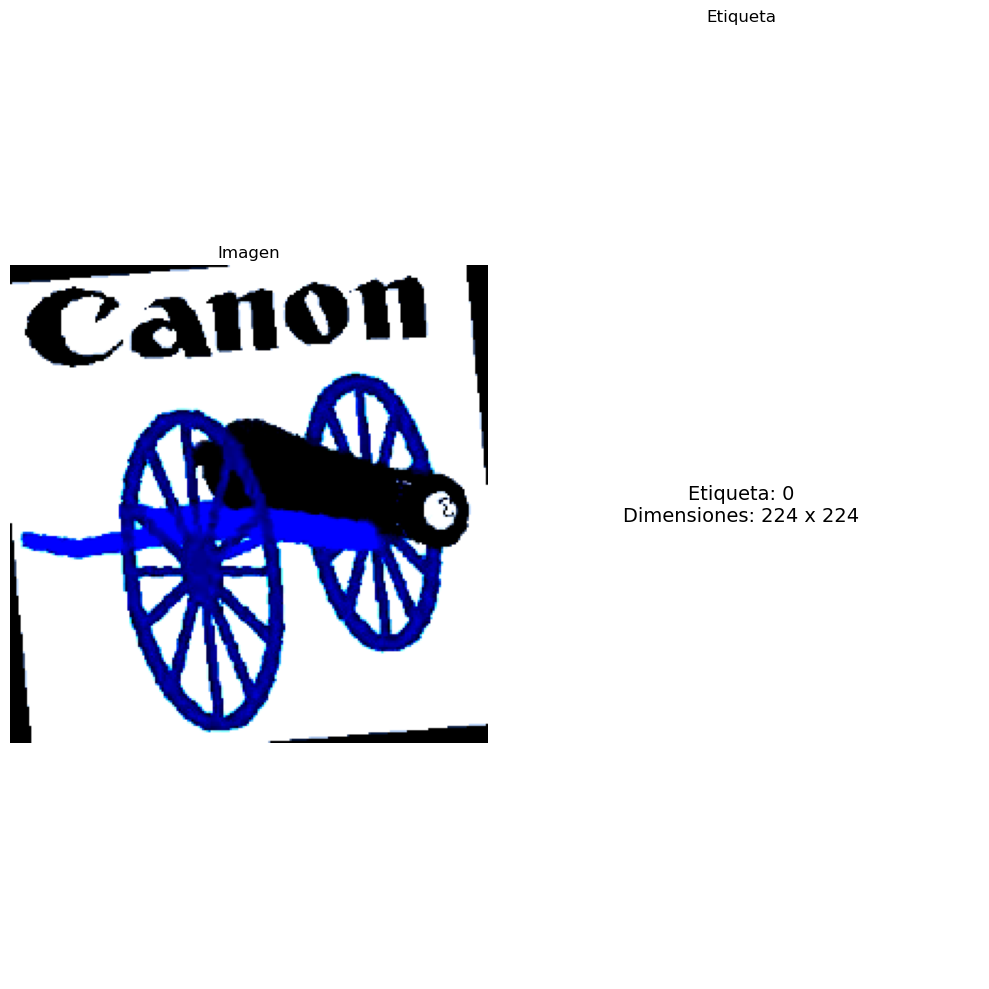

In [12]:
# Obtener una muestra del dataloader
img, label= next(iter(train_loader))

img = img[0]

img_np = img.permute(1, 2, 0).numpy()

label_value = label[0] 

image_height, image_width = img_np.shape[:2]

# Mostrar la imagen y la etiqueta
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Imagen Original
axs[0].imshow(img.permute(1, 2, 0))
axs[0].set_title("Imagen")
axs[0].axis('off')

# Mostrar la etiqueta y las dimensiones
axs[1].text(0.5, 0.5, f'Etiqueta: {label_value}\nDimensiones: {image_height} x {image_width}', ha='center', va='center', fontsize=14)
axs[1].axis('off')
axs[1].set_title("Etiqueta")

plt.tight_layout()
plt.show()

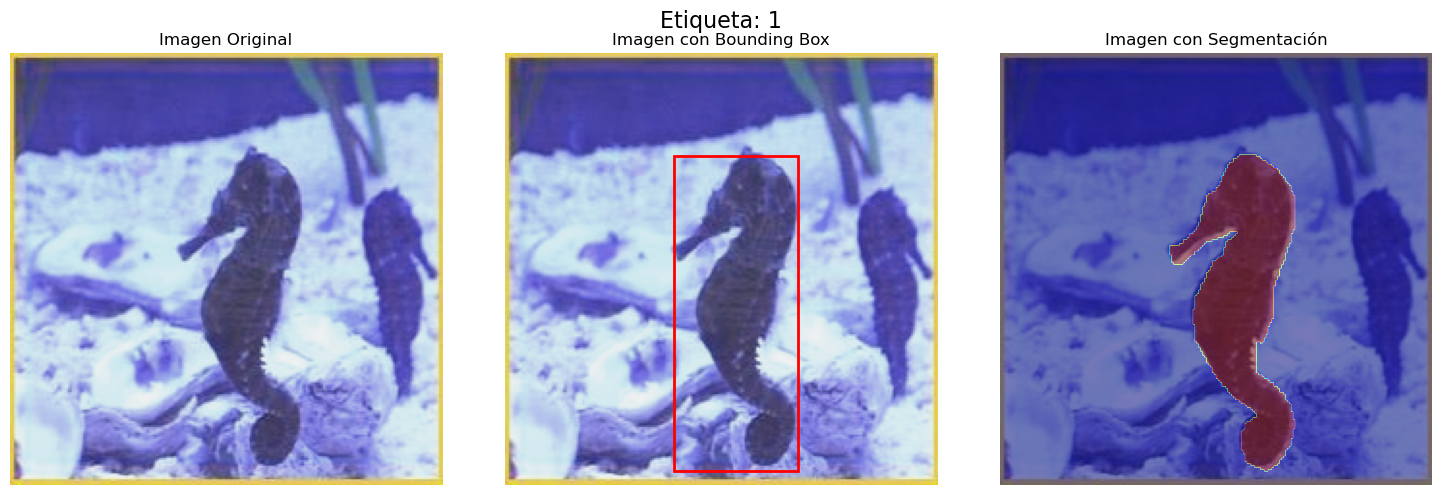

In [13]:
def visualize_image_with_annotations(img, target, label):
    # Convertir la imagen de tensor a formato PIL
    img_pil = F.to_pil_image(img)
    
    # Crear una cuadrícula para la visualización
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Imagen original
    axs[0].imshow(img_pil)
    axs[0].set_title("Imagen Original")
    axs[0].axis("off")
    
    # Imagen con bounding box
    axs[1].imshow(img_pil)
    axs[1].set_title("Imagen con Bounding Box")
    axs[1].axis("off")
    
    for box in target['boxes']:
        # Dibujar el bounding box
        x1, y1, x2, y2 = box.tolist()
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none")
        axs[1].add_patch(rect)
    
    # Imagen con máscara de segmentación
    mask = target['masks'].squeeze(0).numpy()  # Saca la máscara del tensor
    axs[2].imshow(img_pil)
    axs[2].imshow(mask, alpha=0.5, cmap="jet")  # Superponer la máscara
    axs[2].set_title("Imagen con Segmentación")
    axs[2].axis("off")
    
    # Añadir etiqueta
    fig.suptitle(f"Etiqueta: {label}", fontsize=16)
    
    # Mostrar las visualizaciones
    plt.tight_layout()
    plt.show()

# Obtener un lote del data loader
IMAGEN = 1
img, target, label = next(iter(train_loader_mask))

# El primer elemento de target es el diccionario, así que lo extraemos
target_dict = target[IMAGEN]  # Acceder al primer elemento de la tupla (el diccionario)

# Llamar a la función de visualización
visualize_image_with_annotations(img[IMAGEN], target_dict, label[IMAGEN])

# Modelos
A continuación, se explicarán los diferentes modelos que se usarán tanto para clasificación, detección y segmentación. Además, se implementarán y inicializarán.

## Clasificación

ALGO DE TEXTO

### Modelo AlexNet
Cargamos el modelo de AlexNet

In [14]:
modelo_AlexNet = models.alexnet(weights=True)
modelo_AlexNet.classifier = nn.Sequential(
        nn.Dropout(p = 0.5),
        torch.nn.Linear(9216,4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p = 0.5),
        torch.nn.Linear(4096,4096),
        nn.ReLU(inplace=True),
        torch.nn.Linear(4096,2)
    )
if not TRAIN:
    modelo_AlexNet.load_state_dict(torch.load("./models/best_model_AlexNet.pth", weights_only=True))
#print(modelo_AlexNet)

C:\Users\Ramien\anaconda3\envs\AA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Realizamos cambios en el clasificador, no nos interesa realizar nada nuevo para poder hacer comparaciones más justas. Solo cambiaremos la salida de 1000 a 1 (ya que son 2 clases).

### Modelo RestNet

In [15]:
modelo_RestNet = models.resnet50(weights=True)
modelo_RestNet.fc = torch.nn.Linear(2048,2)

if not TRAIN:
    modelo_RestNet.load_state_dict(torch.load("./models/best_model_ResNet.pth", weights_only=True))
#print(modelo_RestNet)

C:\Users\Ramien\anaconda3\envs\AA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Realizamos cambios en el clasificador, no nos interesa realizar nada nuevo para poder hacer comparaciones más justas. Solo cambiaremos la salida de 1000 a 1 (ya que son 2 clases).

### Modelo VGG26

In [16]:
modelo_vgg16 = models.vgg16(weights=True)
modelo_vgg16.classifier = nn.Sequential(
        torch.nn.Linear(25088,4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p = 0.5),
        torch.nn.Linear(4096,4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p = 0.5),
        torch.nn.Linear(4096,2)
        )
if not TRAIN:
    modelo_vgg16.load_state_dict(torch.load("./models/best_model_VGG.pth", weights_only=True))
#print(modelo_vgg16)

C:\Users\Ramien\anaconda3\envs\AA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Realizamos cambios en el clasificador, no nos interesa realizar nada nuevo para poder hacer comparaciones más justas. Solo cambiaremos la salida de 1000 a 1 (ya que son 2 clases).

### Propio: Modelo RubEmNet
En este aparado se desarrollará un modelo desde 0. La idea es crear un modelo pequeño pero que al mismo tiempo de buenos resultados de clasificación.

In [17]:
class RubEmNet(nn.Module):
    def __init__(self):
        super(RubEmNet, self).__init__()
        
        # Extractor de características
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.ReLU(inplace=True), 

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Reducido de 1024 a 512
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        
            nn.ReLU(inplace=True),
        
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
        )
        
        # Promedio global
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))  # Cambia el tamaño a 2x2
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Cargamos el modelo

In [18]:
modelo_RubEmNet = RubEmNet()

if not TRAIN:
    modelo_RubEmNet.load_state_dict(torch.load("./models/best_model_RubEmNet.pth", weights_only=True))
#print(modelo_RubEmNet)

## Detección
De por si Caltech101 no incluye bounding boxes, para ello haciendo uso de Label-Studio nos encargaremos de generar únicamente las bounding boxes de nuestra clase. Únicamente lo haremos la clase que nos corresponde que es ... ya que solo nos interesa dectectar esos objetos.

Los datos se exportarán en formato COCO de esta manera ya se asegura la compatibilidad con ultralytics.

### Modelo YOLO
Para el modelo de YOLO haremos uso de la último versión diponible en ultralytics. Se trata de [YOLO11](https://docs.ultralytics.com/models/yolo11/).

In [19]:
modelo_yolo_det = YOLO("./models/best_model_YOLO_det.pt")

### Modelo MASK R-CNN

In [20]:
modelo_MaskRCNN = models.detection.maskrcnn_resnet50_fpn(weights=models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

In [21]:
def get_model_instance_segmentation(model,num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [22]:
modelo_MaskRCNN = get_model_instance_segmentation(modelo_MaskRCNN,2)
if not TRAIN:
    modelo_MaskRCNN.load_state_dict(torch.load("./models/best_model_MaskRCNN.pth", weights_only=True))
#print(modelo_MaskRCNN)

## Segmentación
De por si Caltech101 no incluye mascaras de segmentación, para ello haciendo uso de Label-Studio nos encargaremos de generar únicamente las mascaras de segmentación de nuestra clase. Únicamente lo haremos la clase que nos corresponde que es ... ya que solo nos interesa dectectar esos objetos.

### Modelo YOLO

In [23]:
modelo_yolo_seg = YOLO("./models/best_model_YOLO_seg.pt")

### Modelo MASK R-CNN

# Clasificación
Apartado centrado en clasificación

Se usa el mismo modelo que se usa en detection

## Congelación de pesos
Es importante congelar los pesos del extractor de características para ...


In [24]:
if TRAIN:
    # Congelación de pesos de AlexNet
    for param in modelo_AlexNet.features.parameters():
       param.requires_grad = False
    for param in modelo_AlexNet.classifier.parameters():
        param.requires_grad = True
    
    # Congelación de pesos de ResNet
    for param in modelo_RestNet.parameters():
        param.requires_grad = False
    
    for param in modelo_RestNet.fc.parameters():
        param.requires_grad = True
        
    #Congelación de pesos de VGG16
    for param in modelo_vgg16.features.parameters():
       param.requires_grad = False
    for param in modelo_vgg16.classifier.parameters():
        param.requires_grad = True

## Definimos la función de entrenamiento
La siguiente función se puede obtener de [pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). La hemos elegido porque nos ha resultado muy interesante como lo plantea. Además, permite guardar en el proceso el modelo con sus pesos y podemos obtener el tiempo de entrenamiento.

Hemos eliminado el parametros scheduler ya que no nos interesa ajustar dinámicamente la tasa de aprendizaje.

In [25]:
def train_model(model, criterion, optimizer, num_epochs=25):
    data_loader = train_loader
    
    print(f"Realizando entrenamiento de {model.__class__.__name__} en el dispositivo {device}")
    model = model.to(device)
    
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in tqdm(range(1, num_epochs + 1)):
            print(f'Epoch {epoch}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in data_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    
                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    
    # Construir la ruta final del modelo
    permanent_model_path = os.path.join(model_dir, f"best_model_{model.__class__.__name__}.pth")

    torch.save(model.state_dict(), permanent_model_path)

    print(f"Modelo guardado en: {permanent_model_path}")

    torch.cuda.empty_cache()

    return model

## Entrenamiento
Una vez que definido la función de entrenamiento estamos preparados para comenzar el entrenamiento de los modelos propios con los nuevos datos.

In [26]:
criterion = nn.CrossEntropyLoss()

# Definimos el optimizer
optimizer_AlexNet = optim.Adam(modelo_AlexNet.parameters(), lr=learning_rate)
optimizer_RestNet = optim.Adam(modelo_RestNet.parameters(), lr=learning_rate)
optimizer_vgg16 = optim.Adam(modelo_vgg16.parameters(), lr=learning_rate)
optimizer_RubEmNet = optim.Adam(modelo_RubEmNet.parameters(), lr=learning_rate)
optimizer_MaskRCNN = optim.Adam(modelo_MaskRCNN.parameters(), lr=learning_rate)

### AlexNet

In [27]:
if TRAIN:
    best_AlexNet = train_model(modelo_AlexNet,criterion,optimizer_AlexNet,EPOCHS)
else: 
    best_AlexNet = modelo_AlexNet

### RestNet

In [28]:
if TRAIN:
    best_RestNet = train_model(modelo_RestNet,criterion,optimizer_RestNet,EPOCHS)
else: 
    best_RestNet = modelo_RestNet

### VGG16

In [29]:
if TRAIN:
    best_vgg16 = train_model(modelo_vgg16,criterion,optimizer_vgg16,EPOCHS)
else: 
    best_vgg16 = modelo_vgg16

### RubEmNet

In [30]:
if TRAIN:
    best_RubEmNet = train_model(modelo_RubEmNet,criterion,optimizer_RubEmNet,EPOCHS)
else:
    best_RubEmNet = modelo_RubEmNet

## Pruebas

En esta sección, nos centramos en la realización de pruebas y obtendremos las métricas necesarias para posteriormente realizar una evaluación. Las principales métricas que usaremos serán:


In [31]:
def calculate_metrics(test_loader, model, device="cuda"):
    """
    Calcula las métricas de Accuracy, Precision, Sensitivity y F1-Score.
    
    Args:
        test_loader: DataLoader con el dataset de prueba.
        model: Modelo entrenado.
        device: Dispositivo para realizar los cálculos ('cuda' o 'cpu').
        
    Returns:
        dict: Diccionario con las métricas calculadas.
    """
    model.eval()
    model.to(device)  # Mover el modelo al dispositivo

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Desactiva el cálculo de gradientes
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Mover datos al dispositivo
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()  # Predicciones
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())  # Mover etiquetas a CPU
    
    # Calcular métricas

    print(all_labels)
    print(all_preds)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="binary")
    sensitivity = recall_score(all_labels, all_preds, average="binary")
    f1 = f1_score(all_labels, all_preds, average="binary")

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Sensitivity (Recall)": sensitivity,
        "F1-Score": f1,
    }

In [32]:
def plot_confusion_matrix(test_loader, model, device="cuda"):
    """
    Genera y muestra una imagen de la matriz de confusión.
    
    Args:
        test_loader: DataLoader con el dataset de prueba.
        model: Modelo entrenado.
    """
    model.eval()
    model.to(device)  # Mover el modelo al dispositivo

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Desactiva el cálculo de gradientes
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Mover datos al dispositivo
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()  # Predicciones
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())  # Mover etiquetas a CPU
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    # Graficar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Matriz de Confusión")
    plt.show()

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j].item()}')
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### AlexNet

In [34]:
metrics = calculate_metrics(test_loader, best_AlexNet)
print(metrics)

[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
{'Accuracy': 1.0, 'Precision': 1.0, 'Sensitivity (Recall)': 1.0, 'F1-Score': 1.0}


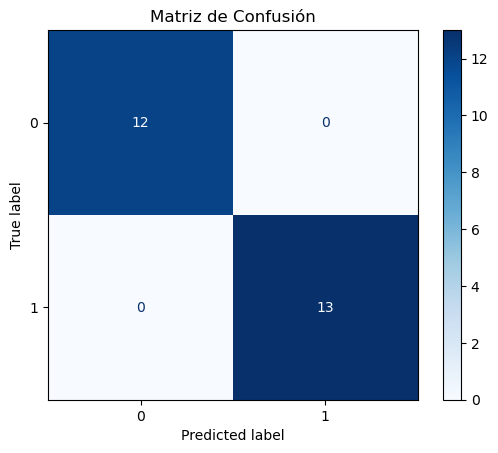

In [35]:
plot_confusion_matrix(test_loader, best_AlexNet)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.9658114].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.981078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.6802621].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.1665784].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.5233415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.5495778].


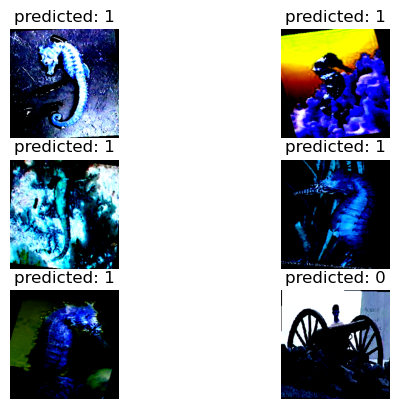

In [36]:
visualize_model(best_AlexNet)

### RestNet

In [37]:
metrics = calculate_metrics(test_loader, best_RestNet)
print(metrics)

[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
{'Accuracy': 1.0, 'Precision': 1.0, 'Sensitivity (Recall)': 1.0, 'F1-Score': 1.0}


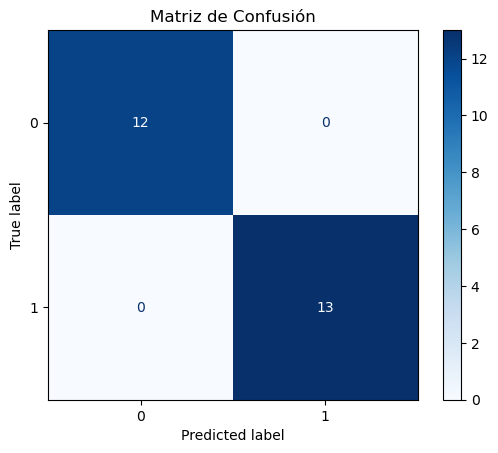

In [38]:
plot_confusion_matrix(test_loader, best_RestNet)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.8927846].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.963841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.8910599].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..2.1153393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..2.005199].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..2.115339].


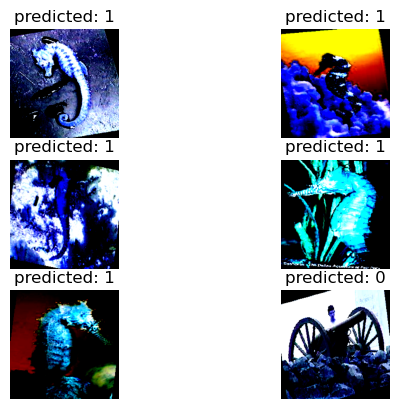

In [39]:
visualize_model(best_RestNet)

### VGG16

In [40]:
metrics = calculate_metrics(test_loader, best_vgg16)
print(metrics)

[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
{'Accuracy': 1.0, 'Precision': 1.0, 'Sensitivity (Recall)': 1.0, 'F1-Score': 1.0}


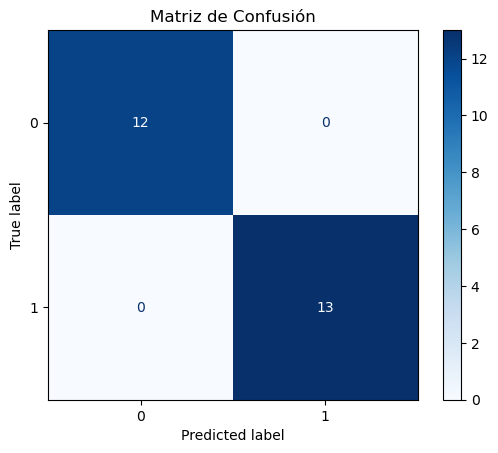

In [41]:
plot_confusion_matrix(test_loader, best_vgg16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..2.112151].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.5515804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..2.0204382].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..2.1023962].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..2.1152453].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.5265769].


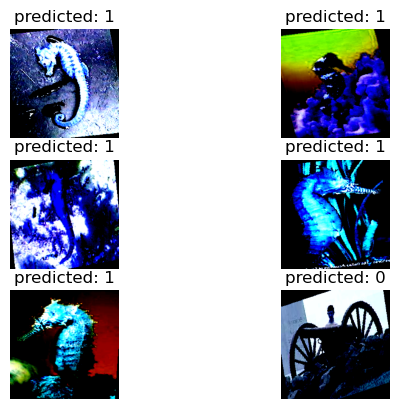

In [42]:
visualize_model(best_vgg16)

### RubEmNet

In [43]:
metrics = calculate_metrics(test_loader, best_RubEmNet)
print(metrics)

[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]
{'Accuracy': 0.76, 'Precision': 0.7058823529411765, 'Sensitivity (Recall)': 0.9230769230769231, 'F1-Score': 0.8}


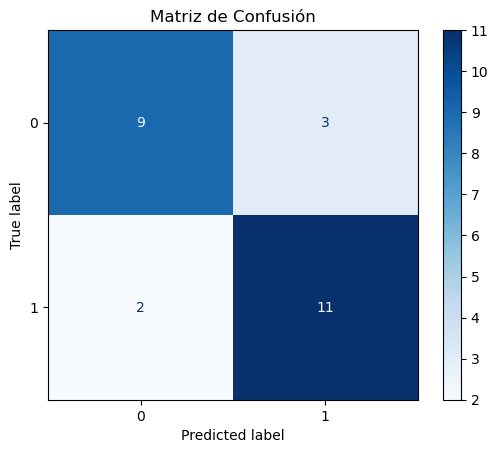

In [44]:
plot_confusion_matrix(test_loader, best_RubEmNet)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..2.1153398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.2372754].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.9418317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..2.1153393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.145406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4764297..1.4790514].


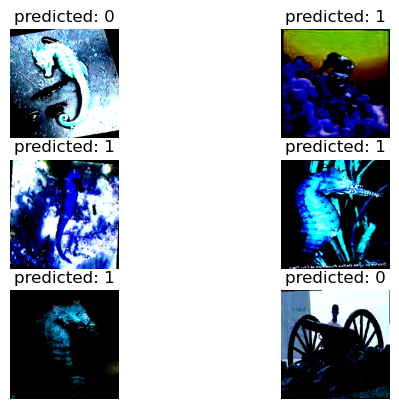

In [45]:
visualize_model(best_RubEmNet)

## Evaluación

## Explicación de los resultados

## Conclusiones clasificación

# Detección
Apartado centrado en detección

## Entrenamiento

### Mask R-CNN

In [46]:
if TRAIN:
    modelo_MaskRCNN = modelo_MaskRCNN.to(device)
    
    t_loss = np.zeros(EPOCHS)
    v_loss = np.zeros(EPOCHS)
    
    pbar = tqdm(range(1, EPOCHS + 1))  # tdqm permet tenir text dinàmic
    
    for epoch in pbar:
    
        train_loss = 0
        val_loss = 0
        modelo_MaskRCNN.train()
    
        for images, targets,_ in train_loader_mask:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
    
            loss_dict = modelo_MaskRCNN(images, targets) # ALERTA: No funciona igual en mode entrenament i mode avaluació.
            losses = sum(loss for loss in loss_dict.values())
    
            optimizer_MaskRCNN.zero_grad()
            losses.backward()
            optimizer_MaskRCNN.step()
            
    torch.cuda.empty_cache()

In [47]:
if TRAIN:
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
        
    # Construir la ruta final del modelo
    permanent_model_path = os.path.join(model_dir, f"best_model_{modelo_MaskRCNN.__class__.__name__}.pth")
    
    torch.save(modelo_MaskRCNN.state_dict(), permanent_model_path)
    
    print(f"Modelo guardado en: {permanent_model_path}")

### YOLO

In [48]:
if TRAIN:
    modelo_yolo_det.train(data="dataset/yolo/detection/caltech_yolo_det.yaml", epochs=100, imgsz=640)
    modelo_yolo_det.export(format="onnx")

## Pruebas

### Mask R-CNN

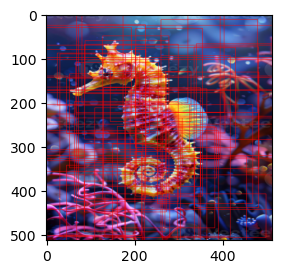

In [49]:
modelo_MaskRCNN.eval()

modelo_maskRCNN = modelo_MaskRCNN.to("cpu")

img = Image.open("dataset/test/sea-horse.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
])

tensor = transform(img)[None, :, :, :]

prediction = modelo_MaskRCNN(tensor)
drawn_boxes = draw_bounding_boxes(tensor[0], prediction[0]['boxes'], colors="red")

plt.subplot(122)
plt.imshow(drawn_boxes.permute(1, 2, 0));

### YOLO


image 1/1 C:\Users\Ramien\Desktop\Carpeta y Archivos\UIB\Aprendizaje Auto\Practicas\P2-AA-UIB-CDS\dataset\test\cannon.jpg: 448x640 1 cannon, 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 47.0ms postprocess per image at shape (1, 3, 448, 640)


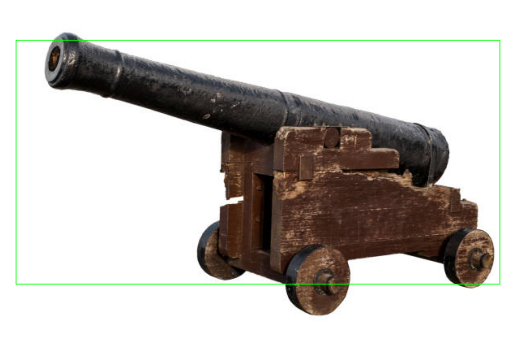

In [50]:
resultado = modelo_yolo_det("dataset/test/cannon.jpg")
resultados = resultado[0].boxes.xyxy.cpu().numpy().astype(int)

imagen = cv2.imread("dataset/test/cannon.jpg")
for r in resultados:
    imagen = cv2.rectangle(imagen, (r[0], r[1]), (r[2], r[3]), (0, 255, 0))

imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
plt.imshow(imagen_rgb)
plt.axis("off")  # Opcional: para ocultar los ejes
plt.show()

## Evaluación

## Explicación de los resultados

## Conclusiones detección

# Segmentación
Apartado centrado en segmentación

## Entrenamiento

### Mask R-CNN
Ya ha sido entrenado anteriormente

### YOLO

In [51]:
if TRAIN:
    modelo_yolo_seg.train(data="dataset/yolo/segmentation/caltech_yolo_seg.yaml", epochs=100, imgsz=640)
    modelo_yolo_seg.export(format="onnx")

## Pruebas

### Mask R-CNN

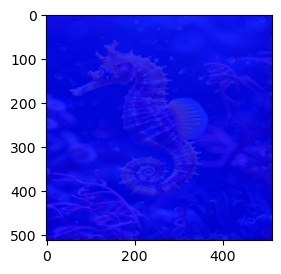

In [52]:
modelo_MaskRCNN.eval()

img = Image.open("dataset/test/sea-horse.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
])

tensor = transform(img)[None, :, :, :]

prediction = modelo_MaskRCNN(tensor)
mask_superposed = draw_segmentation_masks(tensor[0],
                                          masks=(prediction[0]['masks'][0, 0, :, :] > 0.1),
                                          alpha=0.8, colors="blue")

plt.subplot(121)
plt.imshow(mask_superposed.permute(1, 2, 0))

### YOLO


image 1/1 C:\Users\Ramien\Desktop\Carpeta y Archivos\UIB\Aprendizaje Auto\Practicas\P2-AA-UIB-CDS\dataset\test\sea-horse.jpg: 640x448 1 sea-horse, 49.0ms
Speed: 3.0ms preprocess, 49.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)


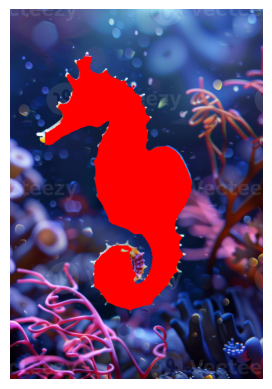

In [53]:
resultado = modelo_yolo_seg("dataset/test/sea-horse.jpg")
mascaras = resultado[0].masks.data.cpu().numpy().astype(int)

imagen = cv2.imread("dataset/test/sea-horse.jpg")
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Colores para cada máscara (puedes definir más colores según sea necesario)
colores = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

# Iterar sobre cada máscara
for i, mascara in enumerate(mascaras):
    # Redimensionar la máscara para que coincida con la imagen
    mascara_resized = cv2.resize(mascara, (imagen.shape[1], imagen.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Aplicar la máscara con el color correspondiente
    color = colores[i % len(colores)]  # Ciclar entre los colores si hay más máscaras que colores
    imagen[mascara_resized == 1] = color

plt.imshow(imagen)
plt.axis("off")  # Opcional: para ocultar los ejes
plt.show()

## Evaluación

## Explicación de los resultados

## Conclusiones segmentación

# Conclusiones finales